In [1]:
import numpy as np
X = np.random.randn(10,10)

In [2]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [3]:
print(c1, c2)

[ 1.07926715e-01 -1.40758478e-01  6.47500440e-01 -2.92171511e-01
  3.75281485e-01  2.49060686e-04  5.17572569e-02  3.78489299e-01
  1.89461603e-01  3.75836328e-01] [ 0.10770712 -0.49623219  0.29132528  0.16497787  0.01423211 -0.16645224
  0.32767223 -0.03688378  0.14738342 -0.68680739]


In [4]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [5]:
X2D

array([[-2.29776297, -1.56968826],
       [ 0.26646253,  3.53382359],
       [-1.23736001, -0.09460993],
       [-3.8571231 ,  0.45188297],
       [ 0.66282628, -1.07599374],
       [ 3.80488498,  0.80749617],
       [ 2.12719484, -0.21239712],
       [-1.96442683,  0.70753625],
       [ 1.1478129 ,  0.03278233],
       [ 1.34749139, -2.58083226]])

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) #define a decomposition model! # why? train and test data should undergo the same method!! -> do not fit under test data!
X2D2 = pca.fit_transform(X)
print(X2D2)

[[ 2.29776297 -1.56968826]
 [-0.26646253  3.53382359]
 [ 1.23736001 -0.09460993]
 [ 3.8571231   0.45188297]
 [-0.66282628 -1.07599374]
 [-3.80488498  0.80749617]
 [-2.12719484 -0.21239712]
 [ 1.96442683  0.70753625]
 [-1.1478129   0.03278233]
 [-1.34749139 -2.58083226]]


In [7]:
print(pca.explained_variance_ratio_)

[0.42279074 0.2121488 ]


In [8]:
pca = PCA() # do not set n_components -> find elements in every dimentions
pca.fit(X) # do not transform -> just learn data
cumsum = np.cumsum(pca.explained_variance_ratio_) # sum elements in list
d = np.argmax(cumsum>0.95) + 1 # -> index of data first greater then 0.95

In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist["data"]
y = mnist["target"]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_train_recovered = pca.inverse_transform(X_train_reduced)

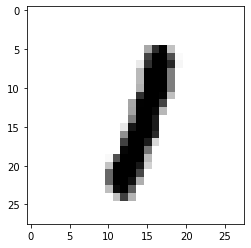

In [12]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0].reshape(28,28), cmap="binary")

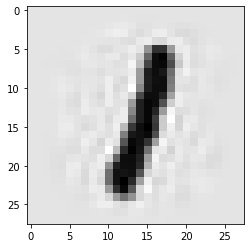

In [13]:
plt.imshow(X_train_recovered[0].reshape(28, 28), cmap="binary")

In [14]:
print(X_train.shape)
print(X_train_reduced.shape)

(56000, 784)
(56000, 154)


In [15]:
rnd_pca = PCA(n_components=0.95, svd_solver="randomized")
X_train_reduced = pca.fit_transform(X_train)
X_train_recovered = pca.inverse_transform(X_train_reduced)

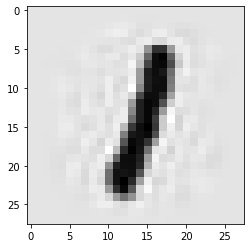

In [16]:
plt.imshow(X_train_recovered[0].reshape(28, 28), cmap="binary")

In [17]:
from sklearn.decomposition import IncrementalPCA # good for online learning!

n_batches = 100
inc_pca = IncrementalPCA(n_components=154) #define class because we need to learn and apply 
for X_batch in np.array_split(X_train, n_batches, axis=0):#np.array_split splits the array with given number of arguments!
    inc_pca.partial_fit(X_batch)
X_test_reduced = inc_pca.transform(X_test)

In [18]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, fit_inverse_transform=True)
X_test_reduced = rbf_pca.fit_transform(X_test)

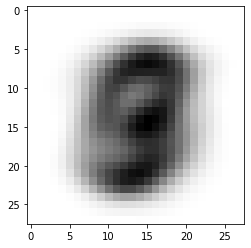

In [19]:
X_test_recovered = rbf_pca.inverse_transform(X_test_reduced)
plt.imshow(X_test_recovered[0].reshape(28, 28), cmap="binary")

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([ #list containing tuples!\
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{ # grid should be a dictionary!
    "kpca__gamma":np.linspace(0.03, 0.05, 10),
    "kpca__kernel":["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_test, y_test)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [21]:
print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}


In [ ]:
from sklearn.manifold import LocallyLinearEmbedding # import lle!
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X_test)